In [10]:
import nltk #Natural Language Tool-kit
from nltk.corpus import brown

In [12]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\SAUMITRA\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\SAUMITRA\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [14]:
corpus = brown.tagged_sents(tagset='universal')

In [16]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [18]:
len(corpus)

57340

In [20]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [24]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3,
)

In [26]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None

# capitalization might be useful - test it
should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK', # Out of Vocabulary
)
# otherwise unknown tokens will be removed and len(input) != len(target)
# input words and target words will not be aligned!

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [28]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 47419 unique tokens.


In [32]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists
def flatten(list_of_lists): # Converts list of list into a single list
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [34]:
""" We need to make sure all targets appear on both training and test set"""

' We need to make sure all targets appear on both training and test set'

In [36]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [38]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [40]:
all_train_targets == all_test_targets

True

In [42]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [44]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [46]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (40138, 180)


In [48]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (17202, 180)


In [50]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (40138, 180)


In [52]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (17202, 180)


In [54]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

In [56]:
# Create the model

# We get to choose embedding dimensionality
D = 32

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero = True)(i) #mask_zero = True --> ANy inputs which are zero will be ignored (including the loss function)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [58]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced
# to be outside the scope of this course
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU
print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 113s 87ms/step - accuracy: 0.0864 - loss: 0.9354 - val_accuracy: 0.1086 - val_loss: 0.1091
Epoch 2/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 136s 108ms/step - accuracy: 0.1103 - loss: 0.0739 - val_accuracy: 0.1093 - val_loss: 0.0878
Epoch 3/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.1110 - loss: 0.0438 - val_accuracy: 0.1094 - val_loss: 0.0853
Epoch 4/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 164s 131ms/step - accuracy: 0.1109 - loss: 0.0319 - val_accuracy: 0.1095 - val_loss: 0.0874
Epoch 5/5
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 135s 108ms/step - accuracy: 0.1110 - loss: 0.0244 - val_accuracy: 0.1094 - val_loss: 0.0927


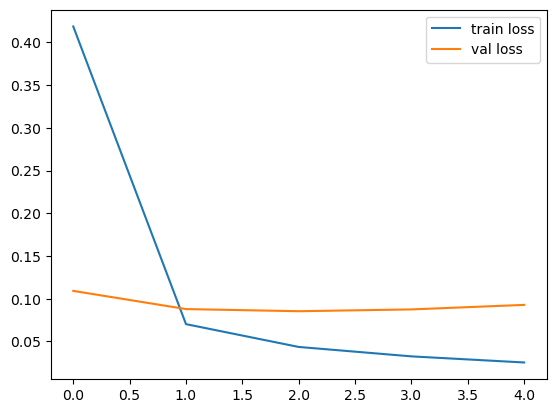

In [60]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

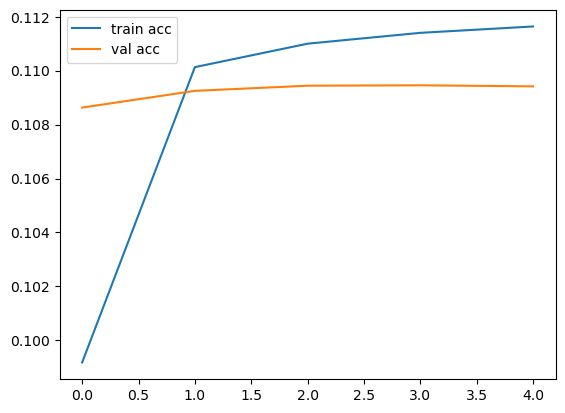

In [62]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [64]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [66]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step


In [67]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

538/538 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step


In [70]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9942815119436464
Test acc: 0.973434088035858
Train f1: 0.9881696718620326
Test f1: 0.9295608236150601


In [72]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [74]:
token2tags = {k: [] for k, v in word2idx.items()}

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [76]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [79]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [81]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9572859686749833
Test acc: 0.9276117687622112
Train f1: 0.9394344974749324
Test f1: 0.8278352212162429
